[Local](./ch06.ipynb),
[Github](https://github.com/renyuanL/_ryDsp2020/blob/master/code/ch06.ipynb),
[Colab](https://colab.research.google.com/github/renyuanL/_ryDsp2020/blob/master/code/ch06.ipynb)

[TextBook@greenteapress](http://greenteapress.com/thinkdsp/html/thinkdsp007.html)

# Chapter 6  Discrete cosine transform

The topic of this chapter is the Discrete Cosine Transform (DCT), which is used in MP3 and related formats for compressing music; JPEG and similar formats for images; and the MPEG family of formats for video.

DCT is similar in many ways to the Discrete Fourier Transform (DFT), which we have been using for spectral analysis. Once we learn how DCT works, it will be easier to explain DFT.

Here are the steps to get there:

1. We’ll start with the synthesis problem: given a set of frequency components and their amplitudes, how can we construct a wave?
1. Next we’ll rewrite the synthesis problem using NumPy arrays. This move is good for performance, and also provides insight for the next step.
1. We’ll look at the analysis problem: given a signal and a set of frequencies, how can we find the amplitude of each frequency component? We’ll start with a solution that is conceptually simple but slow.
1. Finally, we’ll use some principles from linear algebra to find a more efficient algorithm. If you already know linear algebra, that’s great, but I’ll explain what you need as we go.

The code for this chapter is in chap06.ipynb which is in the repository for this book (see Section 0.2). You can also view it at http://tinyurl.com/thinkdsp06.

# 6.1  Synthesis

Suppose I give you a list of amplitudes and a list of frequencies, and ask you to construct a signal that is the sum of these frequency components. Using objects in the thinkdsp module, there is a simple way to perform this operation, which is called synthesis:

```python
def synthesize1(amps, fs, ts):
    
    #  [1] List Comprehension, [2] zip function
    components = [thinkdsp.CosSignal(freq, amp)
                  for amp, freq in zip(amps, fs)] 
    
    # [3] Unpacking Argument Lists
    signal = thinkdsp.SumSignal(*components) 
    

    ys = signal.evaluate(ts)
    return ys
```

amps is a list of amplitudes, fs is the list of frequencies, and ts is the sequence of times where the signal should be evaluated.

components is a list of CosSignal objects, one for each amplitude-frequency pair. SumSignal represents the sum of these frequency components.

Finally, evaluate computes the value of the signal at each time in ts.

----
- review several Python syntax...

[1] [List Comprehension](https://docs.python.org/3/tutorial/datastructures.html#list-comprehensions)
[2] [zip function](https://docs.python.org/3/library/functions.html#zip)
[3] [Unpacking Argument Lists](https://docs.python.org/3/tutorial/controlflow.html#unpacking-argument-lists)

In [48]:
#zip?

In [50]:
amps= [  1,  2,  3,  4]
freqs=[100,200,300,400]
afs= zip(amps, freqs)

for x in afs:
    print(x)

(1, 100)
(2, 200)
(3, 300)
(4, 400)


In [51]:
# afs is a 'generator', after using it, it becomes empty
for x in afs:
    print(x)

In [52]:
# to use afs one more, you need to assign it once again
afs= zip(amps, freqs)
list(afs)

[(1, 100), (2, 200), (3, 300), (4, 400)]

In [53]:
# afs is a 'generator', after using it, it becomes empty
list(afs)

[]

In [59]:
# List comprehension

[x for x in zip(amps, freqs)]


[(1, 100), (2, 200), (3, 300), (4, 400)]

In [60]:
[(a,f) for (a,f) in zip(amps, freqs)]

[(1, 100), (2, 200), (3, 300), (4, 400)]

In [61]:
[(f,a) for (a,f) in zip(amps, freqs)]

[(100, 1), (200, 2), (300, 3), (400, 4)]

In [62]:
[(a,f,a+f,a*f) for (a,f) in zip(amps, freqs)]

[(1, 100, 101, 100),
 (2, 200, 202, 400),
 (3, 300, 303, 900),
 (4, 400, 404, 1600)]

We can test this function like this:

```python
    amps = np.array([0.6, 0.25, 0.1, 0.05])
    fs = [100, 200, 300, 400]
    framerate = 11025

    ts = np.linspace(0, 1, framerate)
    ys = synthesize1(amps, fs, ts)
    wave = thinkdsp.Wave(ys, framerate)
```

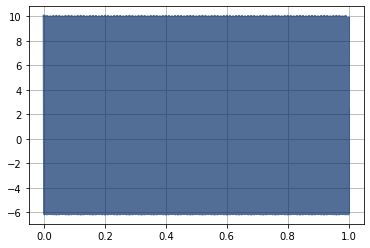

In [110]:
# Let's try it ....
import thinkdsp

def synthesize1(amps, fs, ts):
    
    #  [1] List Comprehension, [2] zip function
    components= [thinkdsp.CosSignal(freq, amp)
                  for amp, freq in zip(amps, fs)] 
    
    # [3] Unpacking Argument Lists
    signal= thinkdsp.SumSignal(*components) 
    
    #ys = signal.evaluate(ts)
    wave= signal.make_wave()
    return wave

amps= [  1,   2,   3,   4] 
fs=   [100, 200, 300, 400]
framerate= 11025
ts= np.linspace(0, 1, framerate+1) 

w= synthesize1(amps, fs, ts)

w.plot()
w.make_audio()



This example makes a signal that contains a fundamental frequency at 100 Hz and three harmonics (100 Hz is a sharp G2). It renders the signal for one second at 11,025 (10,000 or so) frames per second and puts the results into a Wave object.

Conceptually, synthesis is pretty simple. But in this form it doesn’t help much with analysis, which is the inverse problem: given the wave, how do we identify the frequency components and their amplitudes?

# 6.2  Synthesis with numpy arrays


![](http://greenteapress.com/thinkdsp/html/thinkdsp035.png)
Figure 6.1: Synthesis with arrays.

Here’s another way to write synthesize:

```python
def synthesize2(amps, fs, ts):
    args= np.outer(ts, fs)
    M=    np.cos(2*π*args)
    ys=   np.dot(M, amps)
    w=    thinkdsp.Wave(ys)
    return w #ys
```

This function looks very different, but it does the same thing. Let’s see how it works:

1. np.outer() computes the `outer product` of ts and fs. 
    - The result is an array with one row for each element of ts and one column for each element of fs. 
    - Each element in the array is the product of a frequency and a time, $f t$.

1. We multiply args by $2 π$ and apply $cos()$, 
    - so each element of the result is $cos(2 π f t)$. 
    - Since the ts run down the columns, each column contains a cosine signal at a particular frequency, evaluated at a sequence of times.

1. np.dot multiplies each row of M by amps, element-wise, and then adds up the products. 
    - In terms of linear algebra, we are multiplying a matrix, M, by a vector, amps. In terms of signals, we are computing the weighted sum of frequency components.

Figure 6.1 shows the structure of this computation. Each row of the matrix, M, corresponds to a time from 0.0 to 1.0 seconds; tn is the time of the nth row. Each column corresponds to a frequency from 100 to 400 Hz; fk is the frequency of the kth column.

I labeled the nth row with the letters a through d; as an example, the value of a is $cos[2 π (100) tn]$.

The result of the dot product, ys, is a vector with one element for each row of M. The nth element, labeled e, is the sum of products:

$
e = 0.6 a + 0.25 b + 0.1 c + 0.05 d 
$

And likewise with the other elements of ys. So each element of y is the sum of four frequency components, evaluated at a point in time, and multiplied by the corresponding amplitudes. And that’s exactly what we wanted.

We can use the code from the previous section to check that the two versions of synthesize produce the same results.

```python
ys1 = synthesize1(amps, fs, ts)
ys2 = synthesize2(amps, fs, ts)
max(abs(ys1 - ys2))
```
The biggest difference between ys1 and ys2 is about 1e-13, which is what we expect due to `floating-point errors`.

Writing this computation in terms of linear algebra makes the code smaller and faster. Linear algebra provides concise notation for operations on matrices and vectors. For example, we could write synthesize like this:

$
M	=	cos(2 π t ⊗ f) 
y	=	M a
$

where 
- $a$ is a vector of amplitudes, 
- $t$ is a vector of times, 
- $f$ is a vector of frequencies, 
- $⊗$ is the symbol for the `outer product` of two vectors.

In [134]:
import numpy as np

t= np.array([1,2,3,4])
f= np.array([10,20,30,40])

t*f,\
\
t@f,\
t.dot(f),\
\
t.reshape(1,-1)@f.reshape(-1,1),\
t.reshape(1,-1)@f.reshape(-1,1).flatten(),\
\
t.reshape(-1,1)@f.reshape(1,-1),\
np.outer(t,f)

(array([ 10,  40,  90, 160]),
 300,
 300,
 array([[300]]),
 array([300]),
 array([[ 10,  20,  30,  40],
        [ 20,  40,  60,  80],
        [ 30,  60,  90, 120],
        [ 40,  80, 120, 160]]),
 array([[ 10,  20,  30,  40],
        [ 20,  40,  60,  80],
        [ 30,  60,  90, 120],
        [ 40,  80, 120, 160]]))

In [130]:
# Let's compare  synthesize1 & synthesize2 ....

π= np.pi

import thinkdsp

def synthesize1(amps, fs, ts):

    components= [thinkdsp.CosSignal(freq, amp)
                  for amp, freq in zip(amps, fs)]     
    signal= thinkdsp.SumSignal(*components)     
    ys=     signal.evaluate(ts)
    return ys

def synthesize2(amps, fs, ts):
    
    args= np.outer(ts, fs)
    M=    np.cos(2*π*args)
    ys=   np.dot(M, amps)
    
    #ys=   M @ amps.reshape(-1,1)
    #ys=   ys.flatten()
    
    return ys

amps= np.array([  1,   2,   3,   4,   5])
fs=   np.array([100, 200, 300, 400, 500])

framerate= 10000
ts= np.linspace(0, 1, framerate+1) 

ys1= synthesize1(amps, fs, ts)
ys2= synthesize2(amps, fs, ts)

np.abs(ys1-ys2).max(), \
np.allclose(ys1, ys2)

(4.864775249302511e-12, True)

# 6.3  Analysis

Now we are ready to solve the analysis problem. Suppose I give you a wave and tell you that it is the sum of cosines with a given set of frequencies. How would you find the amplitude for each frequency component? In other words, given ys, ts and fs, can you recover amps?

In terms of linear algebra, the first step is the same as for synthesis: we compute M = cos(2 π t ⊗ f). Then we want to find a so that $M a = y $; in other words, we want to solve a linear system. NumPy provides linalg.solve, which does exactly that.

Here’s what the code looks like:

```python
def analyze1(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.linalg.solve(M, ys)
    return amps
```

The first two lines use ts and fs to build the matrix, $M$. Then np.linalg.solve computes amps.

But there’s a hitch. In general we can only solve a system of linear equations if `the matrix is square`; that is, the number of equations (rows) is the same as the number of unknowns (columns).

In this example, we have only 4 frequencies, but we evaluated the signal at 11,025 times. So we have many more equations than unknowns.

In general if ys contains more than 4 elements, it is unlikely that we can analyze it using only 4 frequencies.

But in this case, we know that the ys were actually generated by adding only 4 frequency components, so we can use any 4 values from the wave array to recover amps.

For simplicity, I’ll use the first 4 samples from the signal. Using the values of ys, fs and ts from the previous section, we can run analyze1 like this:

```python
n = len(fs) # len(fs) << len(ts) in this case
amps2 = analyze1(ys[:n], fs, ts[:n])
```

And sure enough, amps2 is

[ 0.6   0.25  0.1   0.05 ]

This algorithm works, but it is slow. 
Solving a linear system of equations takes time proportional to $n^3$, 
where n is the number of columns in M. 

We can do better.... 
but let's play with np.linalg.solve() for a while..

In [ ]:
import numpy as np
π= np.pi

t= np.array([.1,.2,.3,.4]).reshape(-1,1)
f= np.array([ 1, 2, 3, 4]).reshape(1,-1)
a= np.array([10, 20,30,40]).reshape(-1,1)

In [231]:
t, t.shape

(array([[0.1],
        [0.2],
        [0.3],
        [0.4]]), (4, 1))

In [232]:
f, f.shape

(array([[1, 2, 3, 4]]), (1, 4))

In [233]:
a, a.shape

(array([[10],
        [20],
        [30],
        [40]]), (4, 1))

In [234]:
M= t@f
M= np.cos(M*π*2)
M, M.shape

(array([[ 0.80901699,  0.30901699, -0.30901699, -0.80901699],
        [ 0.30901699, -0.80901699, -0.80901699,  0.30901699],
        [-0.30901699, -0.80901699,  0.80901699,  0.30901699],
        [-0.80901699,  0.30901699,  0.30901699, -0.80901699]]), (4, 4))

In [235]:
y= M @ a
y, y.shape

(array([[-27.36067977],
        [-25.        ],
        [ 17.36067977],
        [-25.        ]]), (4, 1))

In [236]:
a1= np.linalg.solve(M, y)
a1, a1.shape

(array([[10.],
        [20.],
        [30.],
        [40.]]), (4, 1))

In [237]:
a2= np.linalg.inv(M) @ y
a2, a2.shape

(array([[10.],
        [20.],
        [30.],
        [40.]]), (4, 1))

# 6.4  Orthogonal matrices

One way to solve linear systems is by `inverting matrices`. 
- The inverse of a matrix $M$ is written $M^{−1}$, 
- and it has the property that $M^{−1} \cdot M = I$. 
- $I$ is the identity matrix, which has the value $1$ on all diagonal elements and $0$ everywhere else.

So, to solve the equation $y = M \cdot a$, 
we can multiply both sides by $M^{−1}$, which yields:

$M^{−1}y = M^{−1} M a $

On the right side, we can replace $M^{−1} \cdot M$ with $I$:

$M^{−1} y = I a $

If we multiply I by any vector a, the result is a, so

$M^{−1}y = a $ 

This implies that if we can compute $M^{−1}$ efficiently, 
we can find $a$ with a simple matrix multiplication 
- `np.dot()`
- `np.matmul()`
- `@` operator 

That takes time proportional to $n^2$, which is better than $n^3$.

In [244]:
v1= np.array([1,1,1,1]) 
v2= np.array([1,2,3,4])

v1.dot(v2), v1 @ v2, np.matmul(v1,v2)

(10, 10, 10)

In [247]:
v1=v1.reshape(1,-1)
v2=v2.reshape(-1,1)
v1,v2

(array([[1, 1, 1, 1]]), array([[1],
        [2],
        [3],
        [4]]))

In [248]:
v1.dot(v2), v1 @ v2, np.matmul(v1,v2)

(array([[10]]), array([[10]]), array([[10]]))

In [250]:
v2.dot(v1), v2 @ v1, np.matmul(v2,v1)


(array([[1, 1, 1, 1],
        [2, 2, 2, 2],
        [3, 3, 3, 3],
        [4, 4, 4, 4]]), array([[1, 1, 1, 1],
        [2, 2, 2, 2],
        [3, 3, 3, 3],
        [4, 4, 4, 4]]), array([[1, 1, 1, 1],
        [2, 2, 2, 2],
        [3, 3, 3, 3],
        [4, 4, 4, 4]]))

Inverting a matrix is slow, in general, but some special cases are faster. 

In particular, if $M$ is orthogonal, the inverse of $M$ is just the `transpose` of $M$, written $M^T$. 

In NumPy, transposing an array is a constant-time operation. 
It doesn’t actually move the elements of the array; 
instead, it creates a “view” that changes the way the elements are accessed.

Again, a matrix is orthogonal if its transpose is also its inverse; that is, $M^T = M^{−1}$. That implies that $M^{T} M = I$, which means we can check whether a matrix is orthogonal by computing $M^{T} M$.

So let’s see what the matrix looks like in `def synthesize2()`. In the previous example, $M$ has 11,025 rows, so it might be a good idea to work with a smaller example:

```python
def test1():
    amps = np.array([0.6, 0.25, 0.1, 0.05])
    N = 4.0
    time_unit = 0.001
    ts = np.arange(N) / N * time_unit
    max_freq = N / time_unit / 2
    fs = np.arange(N) / N * max_freq
    ys = synthesize2(amps, fs, ts)
```

amps is the same vector of amplitudes we saw before. 

Since we have 4 frequency components, we’ll sample the signal at 4 points in time. That way, M is square.

ts is a vector of equally spaced sample times in the range from 0 to 1 time unit. 

I chose the time unit to be 1 millisecond, but it is an arbitrary choice, and we will see in a minute that it drops out of the computation anyway.

Since the frame rate is N samples per time unit, the Nyquist frequency is N / time_unit / 2, which is 2000 Hz in this example. 

So fs is a vector of equally spaced frequencies between 0 and 2000 Hz.

With these values of ts and fs, the matrix, M, is:

``` python
[[ 1.     1.     1.     1.   ]
 [ 1.     0.707  0.    -0.707]
 [ 1.     0.    -1.    -0.   ]
 [ 1.    -0.707 -0.     0.707]]
```

You might recognize 0.707 as an approximation of $\sqrt{2}/2$, which is $cos(π)/4$. 

You also might notice that this matrix is symmetric, which means that the element at (j, k) always equals the element at (k, j). This implies that M is its own transpose; that is, $M^T = M$.

But sadly, M is not orthogonal. If we compute $M^{T}M$, we get:

```python
[[ 4.  1. -0.  1.]
 [ 1.  2.  1. -0.]
 [-0.  1.  2.  1.]
 [ 1. -0.  1.  2.]]
```

And that’s not the identity matrix.

# 6.5  DCT-IV

But if we choose ts and fs carefully, we can make M orthogonal. There are several ways to do it, which is why there are several versions of the discrete cosine transform (DCT).

One simple option is to shift ts and fs by a half unit. This version is called DCT-IV, where “IV” is a roman numeral indicating that this is the fourth of eight versions of the DCT.

Here’s an updated version of test1:
```python
def test2():
    amps = np.array([0.6, 0.25, 0.1, 0.05])
    N = 4.0
    ts = (0.5 + np.arange(N)) / N
    fs = (0.5 + np.arange(N)) / 2
    ys = synthesize2(amps, fs, ts)
```    
If you compare this to the previous version, you’ll notice two changes. First, I added 0.5 to ts and fs. Second, I canceled out time_units, which simplifies the expression for fs.

With these values, M is
```python
[[ 0.981  0.831  0.556  0.195]
 [ 0.831 -0.195 -0.981 -0.556]
 [ 0.556 -0.981  0.195  0.831]
 [ 0.195 -0.556  0.831 -0.981]]
``` 

And MTM is
```python
[[ 2.  0.  0.  0.]
 [ 0.  2. -0.  0.]
 [ 0. -0.  2. -0.]
 [ 0.  0. -0.  2.]]
```

Some of the off-diagonal elements are displayed as -0, which means that the floating-point representation is a small negative number. This matrix is very close to 2I, which means M is almost orthogonal; it’s just off by a factor of 2. And for our purposes, that’s good enough.

Because M is symmetric and (almost) orthogonal, the inverse of M is just M/2. Now we can write a more efficient version of analyze:

```python
def analyze2(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.dot(M, ys) / 2
    return amps
```

Instead of using np.linalg.solve, we just multiply by M/2.

Combining test2 and analyze2, we can write an implementation of DCT-IV:

```python
def dct_iv(ys):
    N = len(ys)
    ts = (0.5 + np.arange(N)) / N
    fs = (0.5 + np.arange(N)) / 2
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.dot(M, ys) / 2
    return amps
```
Again, ys is the wave array. We don’t have to pass ts and fs as parameters; dct_iv can figure them out based on N, the length of ys.

If we’ve got it right, this function should solve the analysis problem; that is, given ys it should be able to recover amps. We can test it like this.

```python
amps = np.array([0.6, 0.25, 0.1, 0.05])
N = 4.0
ts = (0.5 + np.arange(N)) / N
fs = (0.5 + np.arange(N)) / 2
ys = synthesize2(amps, fs, ts)
amps2 = dct_iv(ys)
max(abs(amps - amps2))
```

Starting with amps, we synthesize a wave array, then use dct_iv to compute amps2. The biggest difference between amps and amps2 is about 1e-16, which is what we expect due to floating-point errors.

# 6.6  Inverse DCT

Finally, notice that analyze2 and synthesize2 are almost identical. The only difference is that analyze2 divides the result by 2. We can use this insight to compute the inverse DCT:

```python
def inverse_dct_iv(amps):
    return dct_iv(amps) * 2
```
inverse_dct_iv solves the synthesis problem: it takes the vector of amplitudes and returns the wave array, ys. We can test it by starting with amps, applying inverse_dct_iv and dct_iv, and testing that we get back what we started with.

```python
amps = [0.6, 0.25, 0.1, 0.05]
ys = inverse_dct_iv(amps)
amps2 = dct_iv(ys)
max(abs(amps - amps2))
```

Again, the biggest difference is about `1e-16`.

# 6.7  The Dct class

![](http://greenteapress.com/thinkdsp/html/thinkdsp036.png)

Figure 6.2: DCT of a triangle signal at 400 Hz, sampled at 10 kHz.

`thinkdsp` provides a Dct class that encapsulates the DCT in the same way the Spectrum class encapsulates the FFT. To make a Dct object, you can invoke make_dct on a Wave.

```python
signal = thinkdsp.TriangleSignal(freq=400)
wave = signal.make_wave(duration=1.0, framerate=10000)
dct = wave.make_dct()
dct.plot()
```

The result is the DCT of a triangle wave at 400 Hz, shown in Figure 6.2. The values of the DCT can be positive or negative; a negative value in the DCT corresponds to a negated cosine or, equivalently, to a cosine shifted by 180 degrees.

make_dct uses DCT-II, which is the most common type of DCT, provided by scipy.fftpack.

```python
import scipy.fftpack

class Wave:
    def make_dct(self):
        N = len(self.ys)
        hs = scipy.fftpack.dct(self.ys, type=2)
        fs = (0.5 + np.arange(N)) / 2
        return Dct(hs, fs, self.framerate)
```
The results from dct are stored in hs. The corresponding frequencies, computed as in Section 6.5, are stored in fs. And then both are used to initialize the Dct object.

Dct provides make_wave, which performs the inverse DCT. We can test it like this:

```python
wave2 = dct.make_wave()
max(abs(wave.ys-wave2.ys))
```

The biggest difference between ys1 and ys2 is about 1e-16, which is what we expect due to floating-point errors.

make_wave uses scipy.fftpack.idct:

```python
class Dct
    def make_wave(self):
        n = len(self.hs)
        ys = scipy.fftpack.idct(self.hs, type=2) / 2 / n
        return Wave(ys, framerate=self.framerate)
```

Be default, the inverse DCT doesn’t normalize the result, so we have to divide through by 2N.

# 6.8  Exercises

For the following exercises, I provide some starter code in chap06starter.ipynb. Solutions are in chap06soln.ipynb.

`Exercise 1`   

In this chapter I claim that analyze1 takes time proportional to n3 and analyze2 takes time proportional to n2. To see if that’s true, run them on a range of input sizes and time them. In Jupyter, you can use the “magic command” %timeit.
If you plot run time versus input size on a log-log scale, you should get a straight line with slope 3 for analyze1 and slope 2 for analyze2.

You also might want to test dct_iv and scipy.fftpack.dct.

`Exercise 2`   

One of the major applications of the DCT is compression for both sound and images. In its simplest form, DCT-based compression works like this:
Break a long signal into segments.
Compute the DCT of each segment.
Identify frequency components with amplitudes so low they are inaudible, and remove them. Store only the frequencies and amplitudes that remain.
To play back the signal, load the frequencies and amplitudes for each segment and apply the inverse DCT.
Implement a version of this algorithm and apply it to a recording of music or speech. How many components can you eliminate before the difference is perceptible?

In order to make this method practical, you need some way to store a sparse array; that is, an array where most of the elements are zero. NumPy provides several implementations of sparse arrays, which you can read about at http://docs.scipy.org/doc/scipy/reference/sparse.html.

`Exercise 3`   

In the repository for this book you will find a Jupyter notebook called phase.ipynb that explores the effect of phase on sound perception. Read through this notebook and run the examples. Choose another segment of sound and run the same experiments. Can you find any general relationships between the phase structure of a sound and how we perceive it?